# 利用中文微博評價資料進行Bert微調


In [1]:
! pip install transformers datasets
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.6 MB/s eta 0:00:00


## 下載微博評價資料

In [2]:
!wget https://github.com/shhuangmust/AI/raw/refs/heads/113-1/weibo_senti_100k.csv

--2025-01-06 14:30:31--  https://github.com/shhuangmust/AI/raw/refs/heads/113-1/weibo_senti_100k.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shhuangmust/AI/refs/heads/113-1/weibo_senti_100k.csv [following]
--2025-01-06 14:30:32--  https://raw.githubusercontent.com/shhuangmust/AI/refs/heads/113-1/weibo_senti_100k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19699818 (19M) [application/octet-stream]
Saving to: ‘weibo_senti_100k.csv’

weibo_senti_100k.cs 100%[===================>]  18.79M   117MB/s    in 0.2s    

2025-01-06 14:30:34 (117 MB/s) - ‘weibo_senti_100k.csv’ saved [1969981

## 讀取Weibo資料集
- 共有119988筆資料

In [3]:
from datasets import load_dataset, DatasetDict

ds = load_dataset("csv", data_files="weibo_senti_100k.csv")
print(ds)

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'review'],
        num_rows: 119988
    })
})


## 分割資料集
- 80%訓練(train)資料
- 10%測試(test)資料
- 10%驗證(valid)資料


In [4]:
train_testvalid = ds['train'].train_test_split(test_size=0.2)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})


## 進行分詞

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-chinese")

def tokenize_function(examples):
    return tokenizer(examples["review"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

Map:   0%|          | 0/95990 [00:00<?, ? examples/s]

Map:   0%|          | 0/11999 [00:00<?, ? examples/s]

Map:   0%|          | 0/11999 [00:00<?, ? examples/s]

## 為簡化訓練，挑選10000筆作為訓練與測試資料

In [6]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(10000))
print(small_train_dataset)
print(small_eval_dataset)

Dataset({
    features: ['label', 'review', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10000
})
Dataset({
    features: ['label', 'review', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10000
})


## 列印一筆資料出來看

In [7]:
tokenized_datasets["train"][100]

{'label': 1,
 'review': '收了。[爱你] [爱你]//@纸与温暖:亲，这是你的红五月。 // @我爱街拍 :转发微博。',
 'input_ids': [101,
  3119,
  749,
  511,
  138,
  4263,
  872,
  140,
  138,
  4263,
  872,
  140,
  120,
  120,
  137,
  5291,
  680,
  3946,
  3265,
  131,
  779,
  8024,
  6821,
  3221,
  872,
  4638,
  5273,
  758,
  3299,
  511,
  120,
  120,
  137,
  2769,
  4263,
  6125,
  2864,
  131,
  6760,
  1355,
  2544,
  1300,
  511,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


## 本次微調需要得到正面/負面的判斷結果，因此挑選AutoModelForSequenceClassification
- 輸出結果為正面/負面，因此num_labels=2

In [8]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-chinese", num_labels=2)

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 利用TrainingArguments設定微調參數

In [9]:
from transformers import TrainingArguments
import numpy as np
import evaluate

metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(output_dir="test_trainer_chinese", evaluation_strategy="epoch")


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## 利用Trainer進行訓練
- 此處須輸入wandb key

In [10]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,0.106900,0.053838,0.981500
2,0.059100,0.062878,0.981700
3,0.051600,0.054278,0.982400


TrainOutput(global_step=3750, training_loss=0.08790048828125, metrics={'train_runtime': 3737.9345, 'train_samples_per_second': 8.026, 'train_steps_per_second': 1.003, 'total_flos': 7893331660800000.0, 'train_loss': 0.08790048828125, 'epoch': 3.0})

## 利用pipeline進行測試
- LABEL_0：負面
- LABEL_1：正面

In [11]:
from transformers import pipeline
pipe = pipeline("sentiment-analysis", model='test_trainer_chinese/checkpoint-1500', tokenizer=tokenizer)

Device set to use cuda:0


In [12]:
pipe("我喜歡這個產品")

[{'label': 'LABEL_1', 'score': 0.9995537400245667}]

## wandb訓練結果截圖

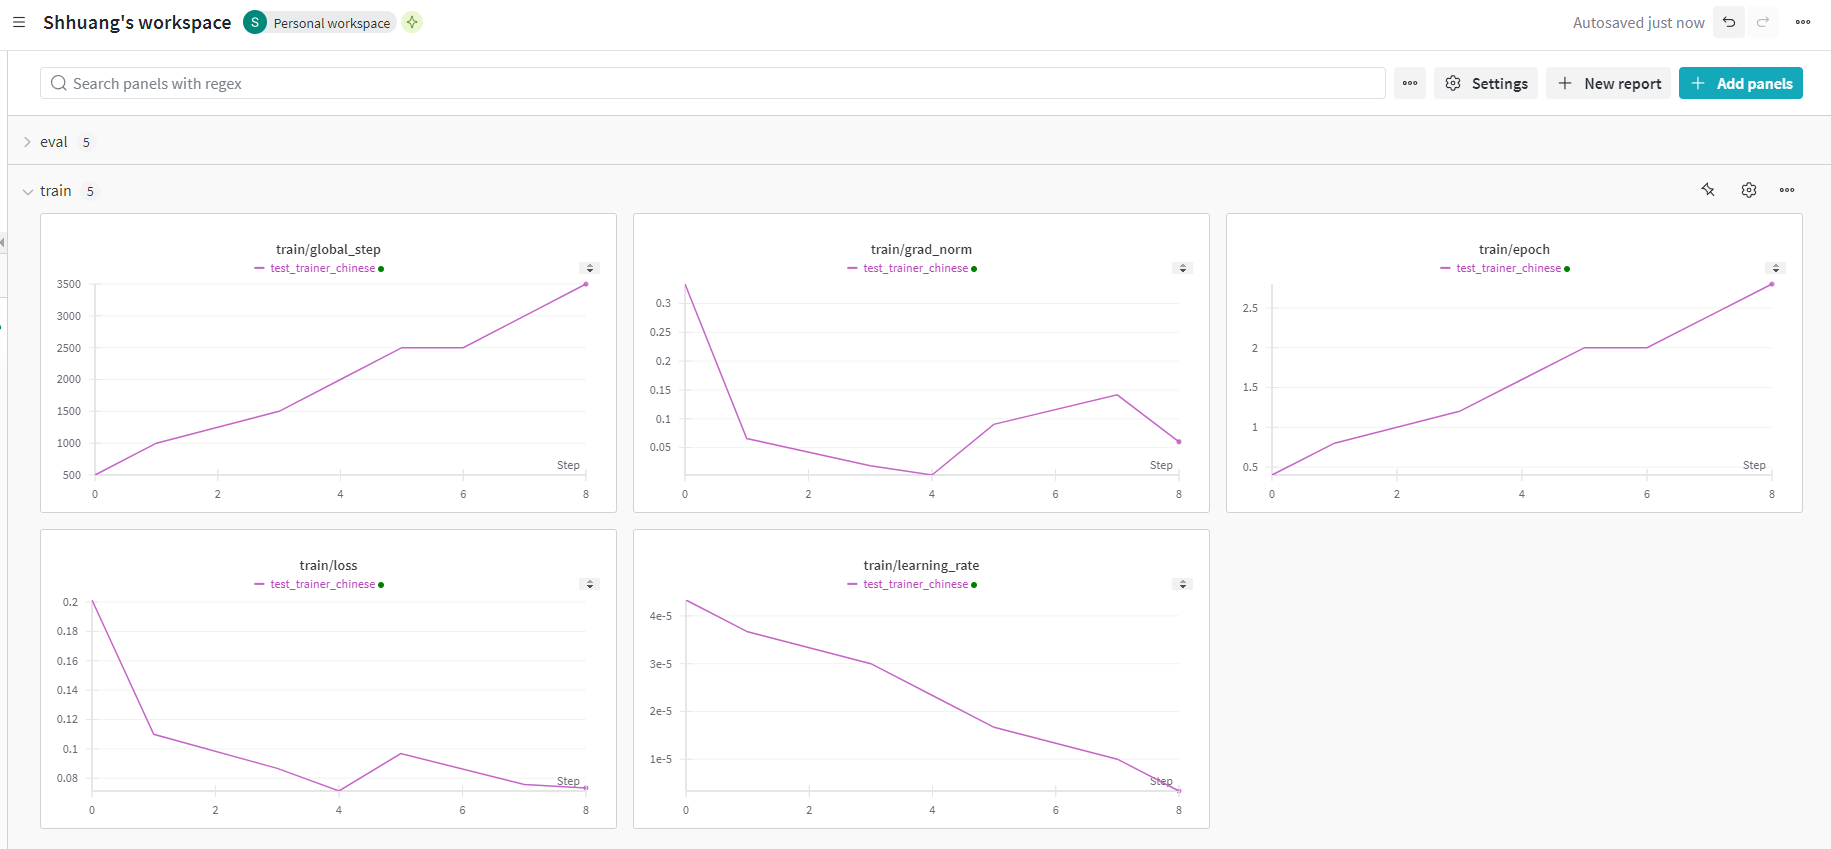

<a id='additional-resources'></a>